In [1]:
%matplotlib inline

In [2]:
import networkx as nx
import numpy as np
import random
import pandas as pd
from scipy.spatial.distance import cosine, cdist
from tqdm import tqdm
from collections import Counter
from itertools import combinations
from random_steiner_tree import random_steiner_tree
from random_steiner_tree.util import from_nx, edges


In [3]:
high = 1
low = 0.0
sampling_method = 'loop_erased'


In [4]:
# g = nx.karate_club_graph()
num_vertices= 6
g = nx.complete_graph(num_vertices, create_using=nx.DiGraph())

if False:
    for u, v in g.edges_iter():
        if u == 0 and v == 1:
            g[u][v]['weight'] = 0.0
        else:
            g[u][v]['weight'] = 1.0
else:            
    for u, v in g.edges_iter():
        g[u][v]['weight'] = (high - low) * np.random.random() + low

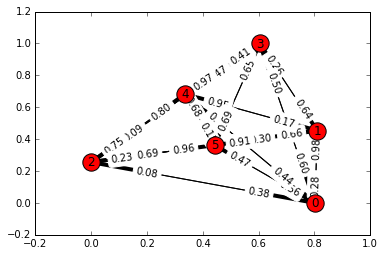

In [5]:
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos=pos)
nx.draw_networkx_labels(g, pos=pos)
nx.draw_networkx_edges(g, pos=pos)
edge_label = {(u, v): '{:.2f}'.format(g[u][v]['weight']) for u, v in g.edges_iter()}
stuff = nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=edge_label, alpha=0.5, label_pos=0.25)
# nx.draw_networkx(g)

In [6]:
gi = from_nx(g)

In [7]:
k = 2
X = np.random.permutation(g.number_of_nodes())[:k]
root = random.choice(list(set(g.nodes()) - set(X)))

In [8]:
print('root = {}'.format(root))
print('terminals = {}'.format(X))
print(g[root][X[0]]['weight'])

root = 5
terminals = [2 4]
0.22730662201456275


In [9]:
def casccade_probability(g, casdade_edges):
    return np.product([g[u][v]['weight'] for u, v in casdade_edges])

In [10]:
assert casccade_probability(g, [(root, X[0])]) == g[root][X[0]]['weight']
assert casccade_probability(g, [(0, 1), (1, 2)]) == (g[0][1]['weight'] * g[1][2]['weight'])

In [51]:
def swap_end_points(edges):
    edges = [(v, u) for u, v in edges]  # pointing towards the root
    return tuple(sorted(edges))

In [12]:
N_SAMPLES = 1000000
def run_experiment(gi, sampling_method, N=N_SAMPLES):
    trees = [swap_end_points(random_steiner_tree(gi, X, root, method=sampling_method))
             for i in tqdm(range(N))]
    tree_freq = Counter(trees)
    return tree_freq

In [13]:
tree_freq = run_experiment(gi, 'cut')

100%|██████████| 1000000/1000000 [00:21<00:00, 46664.99it/s]


In [50]:
list(tree_freq.keys())[0], root, X

(((0, 1), (1, 5), (2, 0), (3, 5), (4, 3)), 5, array([2, 4]))

In [14]:
possible_trees = list(tree_freq.keys())
tree_probas = np.array([tree_freq[t] for t in possible_trees]) / N_SAMPLES

In [15]:
cascade_probas = np.array([casccade_probability(g, t) for t in possible_trees])
cascade_probas /= cascade_probas.sum()

In [16]:
print('****without adjustment')    
print('cosine similarity(p(T), w(T)):', 1 - cosine(tree_probas, cascade_probas))

****without adjustment
cosine similarity(p(T), w(T)): 0.7423522989964352


In [17]:
# now, let's do the adjustment
# 1. reverse the edge direction
# 2. compute the tree probability
# 3. do importance resampling

In [18]:
# reverse the edge direction
g_rev = g.copy()
for u, v in g.edges_iter():
    if u < v:
        g_rev[u][v]['weight'], g_rev[v][u]['weight'] = g_rev[v][u]['weight'], g_rev[u][v]['weight']
gi_rev = from_nx(g_rev)

In [19]:
def tree_proba(g, edges):
    numer = np.product([g[u][v]['weight'] for u, v in edges])
    denum = np.product([g.out_degree(u, weight='weight') for u, v in edges])
    
    return numer / denum

In [20]:
tree_freq_rev = run_experiment(gi_rev, 'cut')
possible_trees_rev = list(tree_freq.keys())

100%|██████████| 1000000/1000000 [00:23<00:00, 42464.27it/s]


In [21]:
# tree_probas_rev = np.array([tree_proba(g_rev, t) for t in possible_trees_rev])
# tree_probas_rev /= tree_probas_rev.sum()
tree_probas_rev = np.array([tree_freq_rev[t] for t in possible_trees_rev]) / N_SAMPLES
cascade_probas = np.array([casccade_probability(g, t) for t in possible_trees_rev])
cascade_probas /= cascade_probas.sum()

In [22]:
print('****only reverse')    
print('cosine similarity(p(T), w(T)):', 1 - cosine(tree_probas_rev, cascade_probas))

****only reverse
cosine similarity(p(T), w(T)): 0.4113350181745391


In [42]:
trees = [swap_end_points(random_steiner_tree(gi_rev, X, root, method='cut'))
         for i in tqdm(range(N_SAMPLES))]

possible_trees_rev = set(trees)
p_tbl = {t: casccade_probability(g_rev, t) for t in possible_trees_rev}
pi_tbl = {t: tree_proba(g_rev, t) for t in possible_trees_rev}


100%|██████████| 1000000/1000000 [00:19<00:00, 50394.29it/s]


In [43]:
p_T = np.array([p_tbl[t] for t in trees])
pi_T = np.array([pi_tbl[t] for t in trees])
w = p_T / pi_T

In [44]:
w /= w.sum()

In [45]:
resampled_tree_idx = np.random.choice(N_SAMPLES, p=w, replace=True, size=N_SAMPLES)
resampled_trees = [trees[i] for i in resampled_tree_idx]

In [40]:
list(possible_trees_rev)[0], root, X

(((1, 5), (2, 1), (3, 2), (4, 3)), 5, array([2, 4]))

In [46]:
resampled_tree_feq = Counter(resampled_trees)
resampled_tree_probas = np.array([resampled_tree_feq[t] for t in possible_trees_rev]) / N_SAMPLES
cascade_probas = np.array([casccade_probability(g_rev, t) for t in possible_trees_rev])
cascade_probas /= cascade_probas.sum()

In [47]:
print('****together')    
print('cosine similarity(p(T), w(T)):', 1 - cosine(resampled_tree_probas, cascade_probas))
print('abs distance(p(T), w(T)):', cdist([resampled_tree_probas], [cascade_probas], 'minkowski', p=1.0)[0,0])

****together
cosine similarity(p(T), w(T)): 0.9988340872424405
abs distance(p(T), w(T)): 0.03371986807417958
